## Segmentation

In [1]:
merge_dataset_file_path = "C:/Users/user/OneDrive/Desktop/Onedrive_YuyanDipsy/OneDrive/UM Y4S1/WIA3002 FYP 1 & 2/FYP2/Data/Soapan Santun - Use/merged.csv"

import pandas as pd

merge_df = pd.read_csv(merge_dataset_file_path)
merge_df.head()

merge_df.isna().sum()


customerid                0
city                      0
state                     0
totalOrders               0
totalSpend                0
avgOrderValue             0
lastPurchaseDate          6
firstPurchaseDate         6
daysSinceLastPurchase     6
customerLifetimeMonths    0
purchaseFrequency         0
favoritePaymentMethod     6
favoriteItem              6
favoritePurchaseHour      6
favoriteDayPart           6
recency                   6
frequency                 0
monetary                  0
dtype: int64

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

import json
import warnings
warnings.filterwarnings("ignore")

# ====================================================
#  FIXED ENCODING / SCALING CONFIG (Production-style)
# ====================================================
# Categorical encoding strategy (fixed, not adaptive):
#   Favourite Payment Method  -> One-Hot
#   Favourite Item            -> Frequency Encoding
#   Favourite Day Part        -> One-Hot
#   Age Group                 -> Ordinal
#   Gender                    -> One-Hot
#   State                     -> One-Hot
#   City                      -> Frequency Encoding
# Numeric scaling strategy:
#   RobustScaler: totalSpending, totalOrders, averageOrderValue, recency, purchaseFrequency
#   StandardScaler: customerLifetimeMonths
#   MinMaxScaler: favoritePurchaseHour

AGE_GROUP_ORDER = ['Below 18', '18-24', '25-34', '35-44', '45-54', '55-64', 'Above 65']  # adjust if dataset differs

ROBUST_COLS = ['totalSpend', 'totalOrders', 'avgOrderValue', 'recency', 'purchaseFrequency']
STANDARD_COLS = ['customerLifetimeMonths']  
MINMAX_COLS = ['favoritePurchaseHour']

OHE_COLS = ['favouritePaymentMethod', 'favouriteDayPart', 'gender', 'state']
ORDINAL_COLS = ['age_group']
FREQ_COLS = ['favouriteItem', 'city']

# ====================================================
#  FREQUENCY ENCODING HELPER
# ====================================================
def apply_frequency_encoding(df, columns):
    applied = []
    for col in columns:
        if col in df.columns:
            freq = df[col].value_counts(normalize=True)
            df[col] = df[col].map(freq).fillna(0.0)
            print(f"[LOG - FREQ ENCODE] {col}: unique={freq.shape[0]} range=({df[col].min():.4f},{df[col].max():.4f})")
            applied.append(col)
    return applied

# ====================================================
#  MAIN SEGMENTATION PIPELINE (uses fixed rules above)
# ====================================================

def run_segmentation(df, selected_features):
    """Run segmentation with fixed encoding/scaling rules.
    Steps:
      1. Subset features
      2. Apply frequency encoding to designated high-cardinality categoricals
      3. Build ColumnTransformer: Ordinal, One-Hot, Scalers
      4. Evaluate K (2..10) with silhouette + DBI + inertia (+ size checks)
      5. Choose K via plateau + DBI + practical size constraints
      6. Final KMeans + summary
    Returns JSON-friendly dict.
    """

    usable_df = df[selected_features].copy()

    # Identify types BEFORE manual frequency encoding (object dtype for categoricals)
    categorical_cols = usable_df.select_dtypes(include=['object']).columns.tolist()
    numeric_cols = usable_df.select_dtypes(include=[np.number]).columns.tolist()

    print("[LOG] ================== ENCODING & SCALING SETUP ==================")
    print(f"Selected features: {selected_features}")

    # Apply frequency encoding
    freq_applied = apply_frequency_encoding(usable_df, [c for c in FREQ_COLS if c in categorical_cols])

    # After frequency encoding, those columns become numeric
    # Recompute numeric/categorical splits if needed
    categorical_cols = usable_df.select_dtypes(include=['object']).columns.tolist()
    numeric_cols = usable_df.select_dtypes(include=[np.number]).columns.tolist()

    print(f"Remaining categorical (object) columns: {categorical_cols}")
    print(f"Numeric columns (including frequency encoded): {numeric_cols}")

    # Build transformers list
    transformers = []

    # Ordinal encoding (age-group) if present
    ordinal_present = [c for c in ORDINAL_COLS if c in categorical_cols]
    if ordinal_present:
        transformers.append(
            ('ord_age_group', OrdinalEncoder(categories=[AGE_GROUP_ORDER], handle_unknown='use_encoded_value', unknown_value=-1), ordinal_present)
        )
        print(f"[LOG - ORDINAL] Applied to: {ordinal_present} with order {AGE_GROUP_ORDER}")

    # One-Hot encoding for specified columns that remain categorical
    ohe_present = [c for c in OHE_COLS if c in categorical_cols]
    if ohe_present:
        transformers.append(
            ('cat_ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_present)
        )
        print(f"[LOG - OHE] Applied to: {ohe_present}")

    # Numeric scaling: create per-group scaler transformers only for existing columns
    robust_present = [c for c in ROBUST_COLS if c in numeric_cols]
    standard_present = [c for c in STANDARD_COLS if c in numeric_cols]
    minmax_present = [c for c in MINMAX_COLS if c in numeric_cols]

    for col in robust_present:
        transformers.append((f'robust_{col}', RobustScaler(), [col]))
    if robust_present:
        print(f"[LOG - SCALER] RobustScaler → {robust_present}")

    for col in standard_present:
        transformers.append((f'standard_{col}', StandardScaler(), [col]))
    if standard_present:
        print(f"[LOG - SCALER] StandardScaler → {standard_present}")

    for col in minmax_present:
        transformers.append((f'minmax_{col}', MinMaxScaler(), [col]))
    if minmax_present:
        print(f"[LOG - SCALER] MinMaxScaler → {minmax_present}")

    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

    X = preprocessor.fit_transform(usable_df)
    if hasattr(X, 'toarray'):
        X = X.toarray()

    # Feature name logging
    ohe_feature_count = 0
    if 'cat_ohe' in preprocessor.named_transformers_:
        ohe_feature_count = len(preprocessor.named_transformers_['cat_ohe'].get_feature_names_out(ohe_present))
    print("[LOG - ENCODE RESULT] Shape: {}".format(X.shape))
    print(f"[LOG - ENCODE RESULT] OHE features: {ohe_feature_count}")
    print("===================================================================")

    # ===========================
    # Evaluate K with composite
    # ===========================
    from collections import Counter
    k_results = []
    print("[LOG - K EVAL] ============== KMeans (2..10) with inertia & sizes ==============")
    for k in range(2, 11):
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        dbi = davies_bouldin_score(X, labels)
        inertia = float(km.inertia_)
        counts = Counter(labels)
        sizes = [counts[i] for i in range(k)]
        k_results.append({'k': k, 'silhouette': float(sil), 'dbi': float(dbi), 'inertia': inertia, 'sizes': sizes})
        print(f"[K={k}] silhouette={sil:.4f} dbi={dbi:.4f} inertia={inertia:.0f} sizes={sizes}")

    # Composite selection: silhouette plateau + DBI threshold + size sanity + target K range
    import pandas as pd
    kr = pd.DataFrame(k_results)
    sil_max = kr['silhouette'].max()
    plateau_cut = 0.95 * sil_max
    # size percentages
    kr['largest_pct'] = kr['sizes'].apply(lambda s: max(s)/sum(s))
    kr['smallest_pct'] = kr['sizes'].apply(lambda s: min(s)/sum(s))
    # thresholds (tunable)
    dbi_max_accept = 1.30
    largest_pct_max = 0.60
    smallest_pct_min = 0.03
    target_k_min, target_k_max = 3, 6
    candidates = kr[(
        (kr['silhouette'] >= plateau_cut) &
        (kr['dbi'] < dbi_max_accept) &
        (kr['largest_pct'] <= largest_pct_max) &
        (kr['smallest_pct'] >= smallest_pct_min) &
        (kr['k'] >= target_k_min) & (kr['k'] <= target_k_max)
    )]
    if candidates.empty:
        # fallback: highest silhouette
        best_row = kr.loc[kr['silhouette'].idxmax()]
        reason = "fallback_max_silhouette"
    else:
        # prefer simpler K unless DBI improves >10%
        candidates = candidates.sort_values('k')
        first = candidates.iloc[0]
        better = candidates[candidates['dbi'] <= first['dbi'] * 0.90]
        best_row = better.iloc[0] if not better.empty else first
        reason = "plateau_DBI_size_range_pref_lower_K"

    best_k = int(best_row['k'])
    print(f"[LOG - BEST K] Selected K={best_k} (sil={best_row['silhouette']:.4f}, dbi={best_row['dbi']:.4f}, inertia={best_row['inertia']:.0f})")
    print("===================================================================")

    # Final model
    final_km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    final_labels = final_km.fit_predict(X)
    df['cluster'] = final_labels

    summary = generate_cluster_summary(df, selected_features)

    decision = {
        'selected_k': int(best_k),
        'silhouette_max': float(sil_max),
        'plateau_threshold': float(plateau_cut),
        'row': {k: (float(v) if isinstance(v, (np.floating, float)) else v) for k, v in best_row.to_dict().items()},
        'criteria': {
            'silhouette_plateau_ratio': 0.95,
            'dbi_max': dbi_max_accept,
            'largest_cluster_pct_max': largest_pct_max,
            'smallest_cluster_pct_min': smallest_pct_min,
            'target_k_range': [target_k_min, target_k_max],
            'reason': reason
        }
    }

    response = {
        'best_k': int(best_k),
        'evaluation': k_results,
        'cluster_assignments': df[['customerid', 'cluster']].to_dict(orient='records') if 'customerid' in df.columns else [],
        'cluster_summary': summary,
        'feature_info': {
            'selected_features': selected_features,
            'ohe_cols': ohe_present,
            'ordinal_cols': ordinal_present,
            'frequency_cols': freq_applied,
            'robust_scaled': robust_present,
            'standard_scaled': standard_present,
            'minmax_scaled': minmax_present,
            'transformed_shape': list(X.shape)
        },
        'decision': decision
    }
    return response

# ====================================================
#  CLUSTER SUMMARY GENERATION
# ====================================================

def generate_cluster_summary(df, selected_features):
    clusters = df['cluster'].unique()
    out = {}
    for c in clusters:
        part = df[df['cluster'] == c]
        stats = {}
        for col in selected_features:
            if col not in part.columns:
                continue
            if part[col].dtype == 'O':
                # categorical: most frequent value
                stats[col] = str(part[col].value_counts().idxmax())
            else:
                stats[col] = float(part[col].mean())
        out[f'cluster_{c}'] = {
            'count': int(len(part)),
            'percentage': round(len(part) / len(df) * 100, 2),
            'attributes': stats
        }
    return out

# ====================================================
#  EXAMPLE (adjust selected list as needed)
# ====================================================
if __name__ == '__main__':
    df = pd.read_csv(merge_dataset_file_path)
    print(f"[LOG - LOAD] Rows loaded: {len(df)}")

    # Filter: keep customers with at least one order if column exists
    if 'totalOrders' in df.columns:
        before = len(df)
        df = df[df['totalOrders'] > 0].copy()
        print(f"[LOG - FILTER] Removed {before - len(df)} customers with zero orders → {len(df)} remain")

    # For quick test: only recency and purchaseFrequency
    selected = [
        'recency',
        'purchaseFrequency'
    ]

    # Drop rows with NA in any selected feature present
    existing = [c for c in selected if c in df.columns]
    df = df.dropna(subset=existing)
    print(f"[LOG - NA DROP] After dropping NA in existing selected features: {len(df)} rows")

    result = run_segmentation(df, existing)
    print(json.dumps(result, indent=4))

[LOG - LOAD] Rows loaded: 3199
[LOG - FILTER] Removed 6 customers with zero orders → 3193 remain
[LOG - NA DROP] After dropping NA in existing selected features: 3193 rows
[LOG] ================== ENCODING & SCALING SETUP ==================
Selected features: ['recency', 'purchaseFrequency']
Remaining categorical (object) columns: []
Numeric columns (including frequency encoded): ['recency', 'purchaseFrequency']
[LOG - SCALER] RobustScaler → ['recency', 'purchaseFrequency']
[LOG - ENCODE RESULT] Shape: (3193, 2)
[LOG - ENCODE RESULT] OHE features: 0
[LOG - K EVAL] ============== KMeans (2..10) with inertia & sizes ==============
[K=2] silhouette=0.5456 dbi=0.7847 inertia=2415 sizes=[2682, 511]
[K=2] silhouette=0.5456 dbi=0.7847 inertia=2415 sizes=[2682, 511]
[K=3] silhouette=0.4445 dbi=0.8453 inertia=1555 sizes=[920, 511, 1762]
[K=3] silhouette=0.4445 dbi=0.8453 inertia=1555 sizes=[920, 511, 1762]
[K=4] silhouette=0.4896 dbi=0.7377 inertia=1131 sizes=[1234, 171, 813, 975]
[K=4] silhoue

## Visualization 1: K Evaluation Metrics
Compare silhouette score and Davies-Bouldin Index across different K values to understand cluster quality.

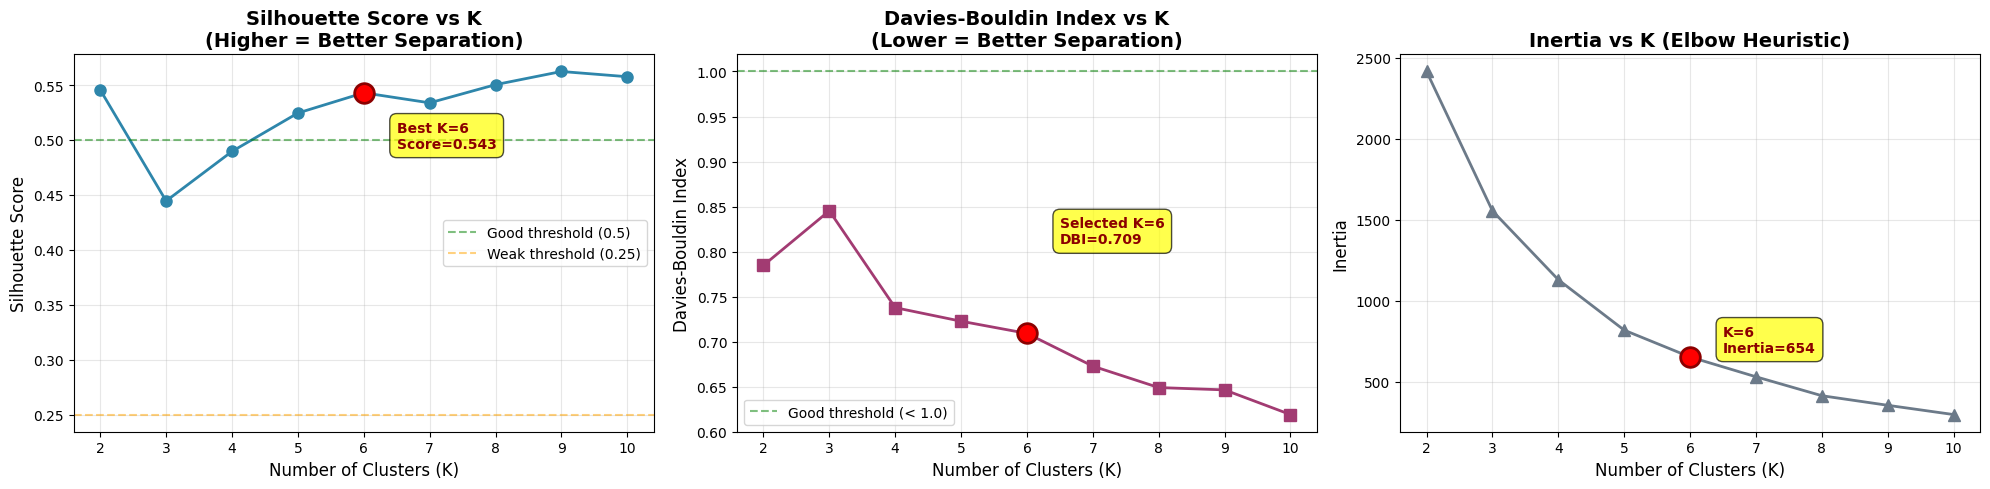


📊 INTERPRETATION GUIDE:
Silhouette Score:
  • Range: -1 to +1
  • > 0.7: Excellent separation
  • 0.5 - 0.7: Good separation
  • 0.25 - 0.5: Moderate structure
  • < 0.25: Weak/overlapping clusters

Davies-Bouldin Index:
  • Range: 0 to ∞
  • < 1.0: Good cluster compactness
  • 1.0 - 2.0: Acceptable
  • > 2.0: Poor separation

Inertia (Elbow):
  • Always decreases as K increases
  • Look for the 'elbow' where improvement slows


In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Extract K evaluation metrics from result
k_values = [r['k'] for r in result['evaluation']]
silhouette_scores = [r['silhouette'] for r in result['evaluation']]
dbi_scores = [r['dbi'] for r in result['evaluation']]
inertias = [r.get('inertia', None) for r in result['evaluation']]
sizes_list = [r.get('sizes', None) for r in result['evaluation']]

# Create figure with three subplots (Silhouette, DBI, Inertia)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: Silhouette Score (Higher is better)
ax1.plot(k_values, silhouette_scores, marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax1.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='Good threshold (0.5)')
ax1.axhline(y=0.25, color='orange', linestyle='--', alpha=0.5, label='Weak threshold (0.25)')
ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
ax1.set_ylabel('Silhouette Score', fontsize=12)
ax1.set_title('Silhouette Score vs K\n(Higher = Better Separation)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xticks(k_values)

# Highlight best K
best_k = result['best_k']
best_silhouette = [r['silhouette'] for r in result['evaluation'] if r['k'] == best_k][0]
ax1.scatter([best_k], [best_silhouette], color='red', s=200, zorder=5, edgecolors='darkred', linewidth=2)
ax1.annotate(f'Best K={best_k}\nScore={best_silhouette:.3f}', 
             xy=(best_k, best_silhouette), 
             xytext=(best_k+0.5, best_silhouette-0.05),
             fontsize=10, color='darkred', fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Plot 2: Davies-Bouldin Index (Lower is better)
ax2.plot(k_values, dbi_scores, marker='s', linewidth=2, markersize=8, color='#A23B72')
ax2.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Good threshold (< 1.0)')
ax2.set_xlabel('Number of Clusters (K)', fontsize=12)
ax2.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax2.set_title('Davies-Bouldin Index vs K\n(Lower = Better Separation)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xticks(k_values)

# Highlight best K
best_dbi = [r['dbi'] for r in result['evaluation'] if r['k'] == best_k][0]
ax2.scatter([best_k], [best_dbi], color='red', s=200, zorder=5, edgecolors='darkred', linewidth=2)
ax2.annotate(f'Selected K={best_k}\nDBI={best_dbi:.3f}', 
             xy=(best_k, best_dbi), 
             xytext=(best_k+0.5, best_dbi+0.1),
             fontsize=10, color='darkred', fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Plot 3: Inertia (Lower is better; elbow heuristic)
if all(x is not None for x in inertias):
    ax3.plot(k_values, inertias, marker='^', linewidth=2, markersize=8, color='#6C7A89')
    ax3.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax3.set_ylabel('Inertia', fontsize=12)
    ax3.set_title('Inertia vs K (Elbow Heuristic)', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(k_values)
    # Highlight best K
    best_inertia = [r['inertia'] for r in result['evaluation'] if r['k'] == best_k][0]
    ax3.scatter([best_k], [best_inertia], color='red', s=200, zorder=5, edgecolors='darkred', linewidth=2)
    ax3.annotate(f'K={best_k}\nInertia={best_inertia:.0f}', 
                 xy=(best_k, best_inertia), 
                 xytext=(best_k+0.5, best_inertia*1.05),
                 fontsize=10, color='darkred', fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
else:
    ax3.text(0.5, 0.5, 'Inertia not available', transform=ax3.transAxes, ha='center', va='center')
    ax3.set_axis_off()

plt.tight_layout()
plt.show()

# Print interpretation guidance
print("\n📊 INTERPRETATION GUIDE:")
print("=" * 60)
print("Silhouette Score:")
print("  • Range: -1 to +1")
print("  • > 0.7: Excellent separation")
print("  • 0.5 - 0.7: Good separation")
print("  • 0.25 - 0.5: Moderate structure")
print("  • < 0.25: Weak/overlapping clusters")
print("\nDavies-Bouldin Index:")
print("  • Range: 0 to ∞")
print("  • < 1.0: Good cluster compactness")
print("  • 1.0 - 2.0: Acceptable")
print("  • > 2.0: Poor separation")
print("\nInertia (Elbow):")
print("  • Always decreases as K increases")
print("  • Look for the 'elbow' where improvement slows")
print("=" * 60)

## Visualization 2: PCA Cluster Scatter Plot
Use PCA to project high-dimensional customer features into 2D space and visualize cluster separation.

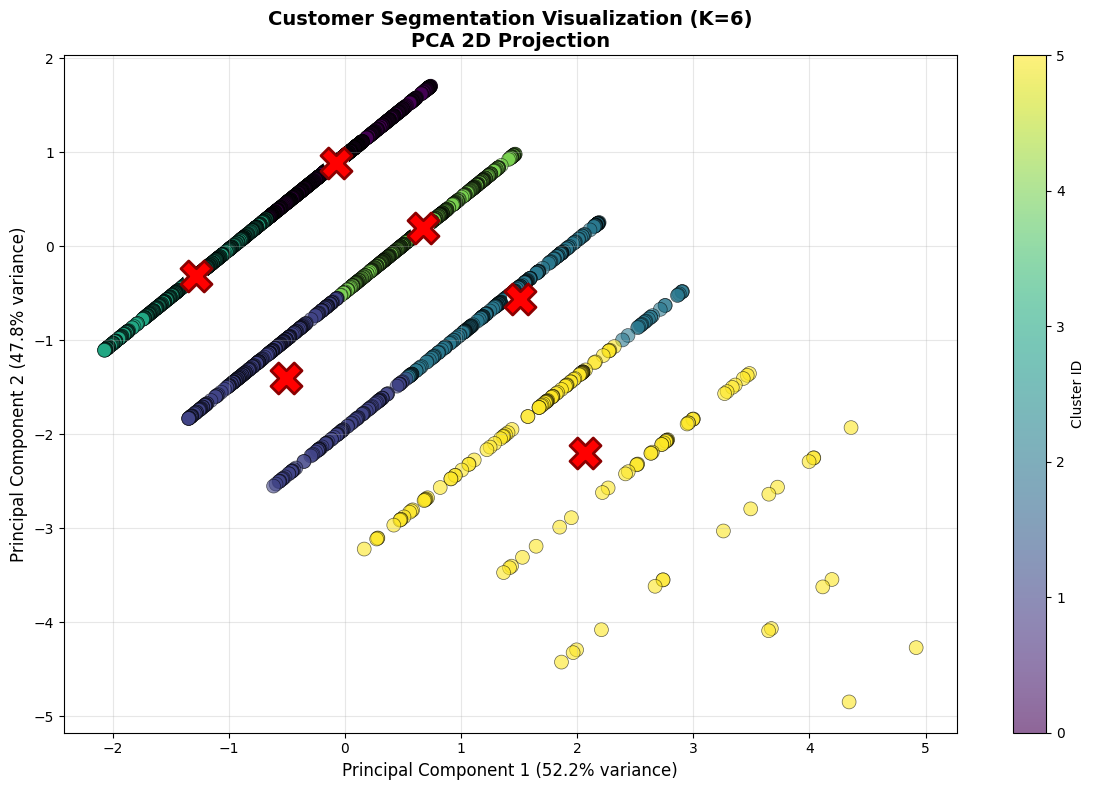


📍 PCA Explained Variance:
   PC1: 52.21%
   PC2: 47.79%
   Total: 100.00% of original variance captured

💡 Note: Overlapping points suggest similar customer profiles within and across clusters.


In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Prepare data for PCA (same preprocessing as clustering)
# Use the same DataFrame and selected feature list from earlier cells
categorical_cols = df[selected].select_dtypes(include=['object']).columns.tolist()
numeric_cols = df[selected].select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

X_scaled = preprocessor.fit_transform(df[selected])
if hasattr(X_scaled, "toarray"):
    X_scaled = X_scaled.toarray()

# Apply PCA to reduce to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Get cluster labels
clusters = df['cluster'].values

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=clusters, 
                     cmap='viridis', 
                     s=100, 
                     alpha=0.6, 
                     edgecolors='black', 
                     linewidth=0.5)

# Add cluster centers
unique_clusters = np.unique(clusters)
for cluster_id in unique_clusters:
    cluster_mask = clusters == cluster_id
    center_x = X_pca[cluster_mask, 0].mean()
    center_y = X_pca[cluster_mask, 1].mean()
    plt.scatter(center_x, center_y, 
               marker='X', 
               s=500, 
               c='red', 
               edgecolors='darkred', 
               linewidth=2, 
               zorder=10,
               label=f'Cluster {cluster_id} Center' if cluster_id == unique_clusters[0] else "")
    plt.annotate(f'C{cluster_id}', 
                xy=(center_x, center_y), 
                fontsize=14, 
                fontweight='bold', 
                color='white',
                ha='center', 
                va='center')

plt.colorbar(scatter, label='Cluster ID')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
plt.title(f'Customer Segmentation Visualization (K={best_k})\nPCA 2D Projection', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📍 PCA Explained Variance:")
print(f"   PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"   PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"   Total: {sum(pca.explained_variance_ratio_)*100:.2f}% of original variance captured")
print("\n💡 Note: Overlapping points suggest similar customer profiles within and across clusters.")

## Visualization 3: Cluster Size Distribution
Show the number and percentage of customers in each segment.

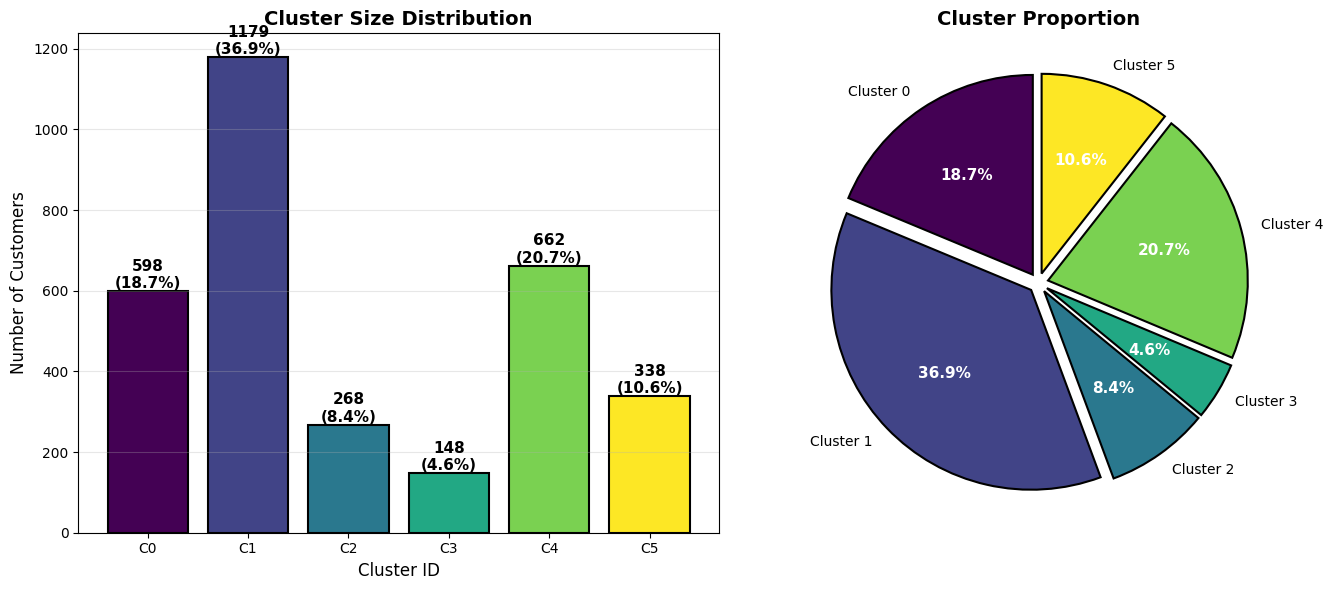


📊 CLUSTER SUMMARY:
Cluster         Count        Percentage      Key Attributes
----------------------------------------------------------------------
Cluster 0       598           18.73%        recency=1110.54, purchaseFrequency=2.00
Cluster 1       1179          36.92%        recency=1097.17, purchaseFrequency=1.00
Cluster 2       268            8.39%        recency=1130.06, purchaseFrequency=3.09
Cluster 3       148            4.64%        recency=876.79, purchaseFrequency=4.61
Cluster 4       662           20.73%        recency=533.24, purchaseFrequency=1.00
Cluster 5       338           10.59%        recency=461.20, purchaseFrequency=2.28


In [5]:
# Extract cluster summary data
cluster_summary = result['cluster_summary']
cluster_names = list(cluster_summary.keys())
cluster_counts = [cluster_summary[c]['count'] for c in cluster_names]
cluster_percentages = [cluster_summary[c]['percentage'] for c in cluster_names]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Bar chart of cluster sizes
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_names)))
bars = ax1.bar(range(len(cluster_names)), cluster_counts, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Cluster ID', fontsize=12)
ax1.set_ylabel('Number of Customers', fontsize=12)
ax1.set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(cluster_names)))
ax1.set_xticklabels([f'C{i}' for i in range(len(cluster_names))])
ax1.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, cluster_counts)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({cluster_percentages[i]:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Pie chart
wedges, texts, autotexts = ax2.pie(cluster_counts, 
                                     labels=[f'Cluster {i}' for i in range(len(cluster_names))],
                                     autopct='%1.1f%%',
                                     startangle=90,
                                     colors=colors,
                                     explode=[0.05]*len(cluster_names),
                                     wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
ax2.set_title('Cluster Proportion', fontsize=14, fontweight='bold')

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.tight_layout()
plt.show()

# Print cluster summary table
print("\n📊 CLUSTER SUMMARY:")
print("=" * 70)
print(f"{'Cluster':<15} {'Count':<12} {'Percentage':<15} {'Key Attributes'}")
print("-" * 70)
for i, cluster_name in enumerate(cluster_names):
    cluster_data = cluster_summary[cluster_name]
    count = cluster_data['count']
    pct = cluster_data['percentage']
    # Show first 2 attributes as preview
    attrs = cluster_data['attributes']
    attr_preview = ', '.join([f"{k}={v:.2f}" if isinstance(v, float) else f"{k}={v}" 
                               for k, v in list(attrs.items())[:2]])
    print(f"Cluster {i:<7} {count:<12} {pct:>6.2f}%        {attr_preview}")
print("=" * 70)